# Hypothesis Testing

Python notebook for illustrating the concept of Hypothesis Testing and specific test statistics; among them the very useful Kolmogorov-Smirnov test.

The Kolmogorov-Smirnov test (KS-test) is a general test to evaluate if two distributions in 1D are the same. This program applies an unbinned KS test, and compares it to a $\chi^2$-test and a simple comparison of means. The distributions compared are two unit Gaussians, where one is then modified by changing:
- Mean
- Width
- Normalisation

The sensitivity of each test is then considered for each of these changes.

### References:
- Barlow: p. 155-156
- __[Wikipedia: Kolmogorov-Smirnov test](http://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test)__
- Though influenced by biostatistics, a good discussion of p-values and their distribution can be found here:
  [How to interpret a p-value histogram?](http://varianceexplained.org/statistics/interpreting-pvalue-histogram/)

### Authors: 
Troels C. Petersen (Niels Bohr Institute)

### Date:    
03-12-2020 (latest update)

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy.special import erfc
from scipy import stats

sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

Set the parameters of the plot:

In [2]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

save_plots = False
verbose = True

The small function below is just a simple helper function that takes a 1D-array input along with an axis, position and color arguments an plot the number of entries, the mean and the standard deviation on the axis:

In [3]:
def ax_text(x, ax, posx, posy, color='k'):
    
    d = {'Entries': len(x), 
         'Mean': x.mean(),
         'STD': x.std(ddof=1),
        }
    
    add_text_to_ax(posx, posy, nice_string_output(d), ax, fontsize=12, color=color)
    return None

and finally a function that calculates the mean, standard deviation and the standard deviation (i.e. uncertainty) on mean (sdom):

In [4]:
def mean_std_sdom(x):
    std = np.std(x, ddof=1)
    return np.mean(x), std, std / np.sqrt(len(x))

## Set up the experiment:

How many experiments, and how many events in each:

In [5]:
N_exp = 1
N_events_A = 100
N_events_B = 100

Define the two Gaussians to be generated (no difference to begin with!):

In [6]:
dist_mean_A  =  0.0
dist_width_A =  1.0
dist_mean_B  =  0.0
dist_width_B =  1.0

Define the number of bins and the range, initialize empty arrays to store the results in and make an empty figure (to be filled in later):

In [7]:
N_bins = 100
xmin, xmax = -5.0, 5.0

all_p_mean = np.zeros(N_exp)
all_p_chi2 = np.zeros(N_exp)
all_p_ks   = np.zeros(N_exp)

# Figure for the two distributions, A and B, in the first experiment:
fig1, ax1 = plt.subplots(figsize=(10, 6))
plt.close(fig1)

Loop over how many times we want to run the experiment, and for each calculate the p-value of the two distributions coming from the same underlying PDF (put in calculations yourself):

   0:  p_mean: 0.50000   p_chi2: 0.50000   p_ks: 0.70206


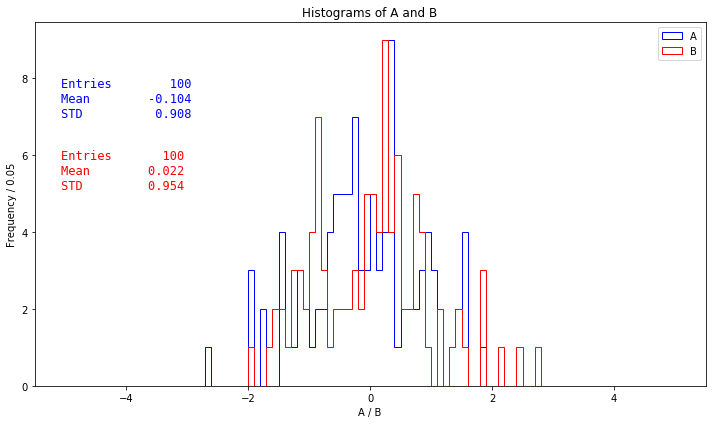

In [8]:
for iexp in range(N_exp):
    if ((iexp+1)%1000 == 0):
        print(f"Got to experiment number: {iexp+1}")

    # Generate data:
    x_A_array = r.normal(dist_mean_A, dist_width_A, N_events_A)
    x_B_array = r.normal(dist_mean_B, dist_width_B, N_events_B)
    
    
    # Test if there is a difference in the mean:
    # ------------------------------------------
    # Calculate mean and error on mean:
    mean_A, width_A, sdom_A = mean_std_sdom(x_A_array) 
    mean_B, width_B, sdom_B = mean_std_sdom(x_B_array) 

    # Consider the difference between means in terms of the uncertainty:
    d_mean = mean_A - mean_B
    # ... how many sigmas is that away?

    # Turn a number of sigmas into a probability (i.e. p-value):
    p_mean    = 0.5      # Calculate yourself. HINT: "stats.norm.cdf or stats.norm.sf may be useful!"
    all_p_mean[iexp] = p_mean
    
    
    # Test if there is a difference with the chi2:
    # --------------------------------------------
    # Chi2 Test:
    p_chi2 = 0.5         # Calculate the p-value of the Chi2 between histograms of A and B yourself.
    all_p_chi2[iexp] = p_chi2

    
    # Test if there is a difference with the Kolmogorov-Smirnov test on arrays (i.e. unbinned):
    # -----------------------------------------------------------------------------------------
    p_ks = stats.ks_2samp(x_A_array, x_B_array)[1]           # Fortunately, the K-S test is implemented in stats!
    all_p_ks[iexp] = p_ks


    # Print the results for the first 10 experiments
    if (verbose and iexp < 10) :
      print(f"{iexp:4d}:  p_mean: {p_mean:7.5f}   p_chi2: {p_chi2:7.5f}   p_ks: {p_ks:7.5f}")

    
    # In case one wants to plot the distribution for visual inspection:
    if (iexp == 0):
        
        ax1.hist(x_A_array, N_bins, (xmin, xmax), histtype='step', label='A', color='blue')
        ax1.set(title='Histograms of A and B', xlabel='A / B', ylabel='Frequency / 0.05')        
        ax_text(x_A_array, ax1, 0.04, 0.85, 'blue')

        ax1.hist(x_B_array, N_bins, (xmin, xmax), histtype='step', label='B', color='red')
        ax_text(x_B_array, ax1, 0.04, 0.65, 'red')
        
        ax1.legend()
        fig1.tight_layout()

        
fig1

## Show the distribution of fit p-values:

In [9]:
N_bins = 50

if (N_exp > 1):
    fig2, ax2 = plt.subplots(nrows=3, figsize=(12, 14))
    
    ax2[0].hist(all_p_mean, N_bins, (0, 1), histtype='step')
    ax2[0].set(title='Histogram, probability mu', xlabel='p-value', ylabel='Frequency / 0.02', xlim=(0, 1))
    ax_text(all_p_mean, ax2[0], 0.04, 0.25)
    

    ax2[1].hist(all_p_chi2, N_bins, (0, 1), histtype='step')
    ax2[1].set(title='Histogram, probability chi2', xlabel='p-value', ylabel='Frequency / 0.02', xlim=(0, 1))
    ax_text(all_p_chi2, ax2[1], 0.04, 0.25)
    
    ax2[2].hist(all_p_ks, N_bins, (0, 1), histtype='step')
    ax2[2].set(title='Histogram, probability Kolmogorov', xlabel='p-value', ylabel='Frequency / 0.02', xlim=(0, 1))
    ax_text(all_p_ks, ax2[2], 0.04, 0.25)

    fig2.tight_layout()


    if save_plots:
        fig2.savefig('PvalueDists.pdf', dpi=600)

# Questions:

1. First run the program with one experiment (N_exp = 1) to display the two distributions A and B, when:
    - They are the same.
    - The mean of A is increased (to e.g. 0.1).
    - The width of A is enlarged (to e.g. 1.2).
    - The normalisation of A is increased.

Get a feel for how much you need to change the distribution, before you can _by eye_ see that they are not the same. I.e. can you see any difference, if `mean_A` $= 0.1$? Or how about $0.2$? How do you quantify this and when do you start to doubt? And how about `width_A` $= 1.1$? Or $1.2$? Again, can you see it by eye? Finally, try to put $1050$ events into B. Is that visible? How about $1100$? And do you see an impact in the p-values?

2. Could you for the test of the means have calculated how much of a change in the mean is needed for a difference to be statistically significant? Do so, and see if it somewhat matches you guess/estimate from above!


3. Now run the tests 1000 times, where A and B are unit Gaussians and thus identical. How should the distributions of the test probabilities come out? And is this the case, approximately? If not, think of reasons for this, and what could be a remedy. HINT: Large statistics is always easier!


4. Repeat the changes in question 1), and see which tests "reacts" most to these modifications. How much of a change in the mean is required for 95% of the tests (of each kind) to give a probability below 5%? How much is required for the width? And the norm?


5. Possibly try to test different distributions than the Gaussian one (e.g. exponential, uniform, etc.), and see how the tests performs.


NOTE: The Kolmogorov-Smirnov test has the great advantage that it can handle ANY distribution (even the Cauchy distribution - remind yourself of that one!). The reason is, that it doesn't care about any PDF, nor how far out an outlier is. It is just a matter of the difference in integrals between the two functions.


## Advanced:

6. Obviously, the test of the means is not sensitive the a change in the width. Make such a test yourself by calculating the widths and the uncertainty on the widths (or perhaps try the F-test!). Note that in a (unit) Gaussian the uncertainty on the width is of the same order as that of the means!


## Very advanced:
7. Implement in python the following tests:
     - Lilliefors test
     - Shapiro-Wilk test
     - Anderson-Darling test
     - Cramer-von-Mises test
     - Jarque-Bera test
     - Kuiper's test
     - Mann-Whitney-Wilcoxon test
     - Siegel-Tukey test
     
and quantify under various conditions and datasets the power of each and the correlation among them. Write it up, and send it to a statistics journal. :-)